<div style="border:solid Chocolate 2px; padding: 40px">

<b> Азат, привет!👋</b>

Меня зовут Алексей Гриб, и я буду ревьюером твоего проекта. 

Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель ревью - не искать ошибки в твоём проекте, а помочь тебе сделать твою работу ещё лучше, устранив недочёты и приблизив её к реальным задачам специалиста по работе с данными. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
критичные ошибки, которые обязательно нужно исправить.
</div>

    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*твой текст*
</div>
    
Давай посмотрим на твой проект!

# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`.

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Хорошее вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!

In [70]:
!pip install sqlalchemy

In [71]:
!pip install psycopg2

In [72]:
!pip install psycopg2-binary

In [73]:
!pip install python-dotenv 

In [74]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import phik
from phik import phik_matrix, resources, report

In [76]:
import os
from dotenv import load_dotenv

load_dotenv()

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('USER'),
    os.getenv('PASSWORD'),
    os.getenv('HOST'),
    os.getenv('PORT'),
    os.getenv('DB'),
)

In [77]:
print(os.getenv('HOST'))

rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net


In [78]:
print(os.getenv('USER'))

praktikum_student


In [79]:
print(os.getenv('PASSWORD'))

Sdf4$2;d-d30pp


In [80]:
print(os.getenv('PORT'))

6432


In [81]:
print( os.getenv('DB'))

data-analyst-afisha


In [82]:
engine = create_engine(connection_string)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали, коннектор сделали - отлично!

In [83]:
query = '''
-- Настройка параметра synchronize_seqscans важна для проверки
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)

SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,  -- берём из purchases, как указано в схеме
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id;
'''

In [84]:
df = pd.read_sql_query(query, con=engine)
df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Глиногорск,Каменевский регион
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Ягодиновка,Широковская область


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Данные из запроса получены.

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [85]:
print(df.shape)      

(290611, 15)


In [86]:
print(df.dtypes)          

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
city_name                        object
region_name                      object
dtype: object


In [87]:
display(df.head())

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Результаты методов вывода `Pandas` не стоит оборачивать в `print` - в этом случае применяет форматирование теста, а не вывод исходной таблицы.

In [88]:
print(df.info())                            

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [89]:
print(df.isnull().sum()) 

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
city_name                    0
region_name                  0
dtype: int64


В представленном датасете 290611 строк и 15 столбцов.

В таблице представлены данные разных типов (целочисленные значения, значения с палвающей точкой, строковый тип данных, данные типа datetime).

Пропуски обнаружены в столбце `days_since_prev` (21933 пропуска).

Далее, на следующем этапе (обработка данных), будем работать над пропусками, проверим датасет на наличие дубликатов и проанализируем категориальные признаки.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Пропуски проанализироавны.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> В выводе нужно наметить шаги по обработке данных.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [91]:
url = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
df_1 = pd.read_csv(url)
df_1

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
...,...,...,...,...
352,2024-12-27,100,19.2705,kzt
353,2024-12-28,100,19.5105,kzt
354,2024-12-29,100,19.4860,kzt
355,2024-12-30,100,19.4860,kzt


In [92]:
df_1['data'] = pd.to_datetime(df_1['data'])

df_1['rate_per_tenge'] = round(df_1['curs'] / df_1['nominal'], 3)

df = df.merge(
    df_1[['data','rate_per_tenge']],
    left_on='order_dt',
    right_on='data',
    how='left'
)

def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']  
    elif row['currency_code'] == 'kzt':
        return row['revenue'] * row['rate_per_tenge'] 

df['revenue_rub'] = df.apply(convert_to_rub, axis=1)

In [93]:
df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,rate_per_tenge,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,2024-08-20,0.187,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,2024-07-23,0.183,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,2024-10-06,0.196,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,2024-07-13,0.185,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,2024-10-04,0.197,1390.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,0.199,1448.36
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион,2024-10-27,0.199,965.57
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Глиногорск,Каменевский регион,2024-10-30,0.200,178.95
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Ягодиновка,Широковская область,2024-09-24,0.194,661.53


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выручка приведена к единой валюте.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Единственный столбец с пропусками (`days_since_prev`) оставим без изменений, поскольку для некоторых строк значение NaN должно быть по условию.

Данные с датой и временем указаны правильно. Числовые данные сокращены нормально.

In [94]:
print("Статистика по revenue_rub:")
print(df['revenue_rub'].describe())

print("\nСтатистика по tickets_count:")
print(df['tickets_count'].describe())

Статистика по revenue_rub:
count    290611.000000
mean        555.579833
std         875.511158
min         -90.760000
25%         113.970000
50%         351.140000
75%         802.050000
max       81174.540000
Name: revenue_rub, dtype: float64

Статистика по tickets_count:
count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


По статистическим данным видно, что основное количество значений столбца `revenue_rub` не превышает значение *1000*, а столбца `tickets_count` - не превышает значение *4*. Также наблюдаются предполагаемые выбросы, сравнивая среднее (**mean**) и максимальное значения (**max**).

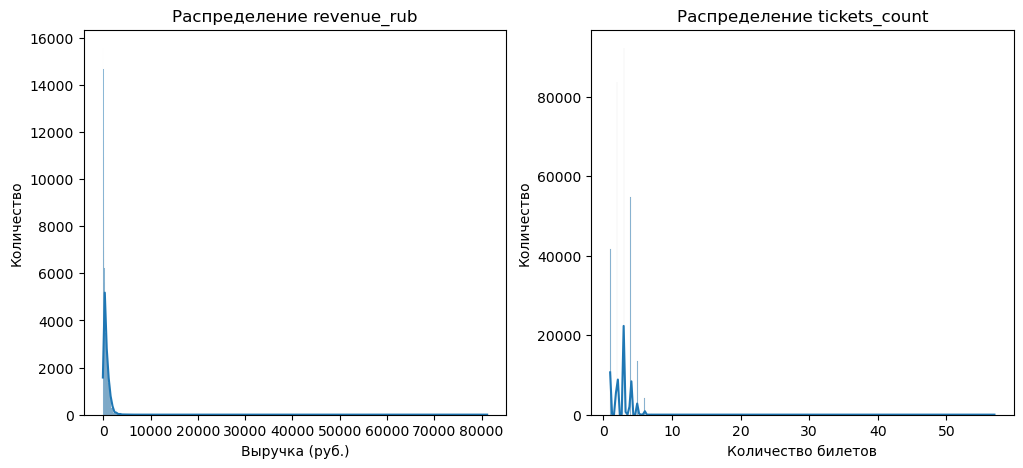

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['revenue_rub'], kde=True, ax=axes[0])
axes[0].set_title('Распределение revenue_rub')
axes[0].set_ylabel('Количество')
axes[0].set_xlabel('Выручка (руб.)')

sns.histplot(df['tickets_count'], kde=True, ax=axes[1])
axes[1].set_title('Распределение tickets_count')
axes[1].set_ylabel('Количество')
axes[1].set_xlabel('Количество билетов')


plt.show()

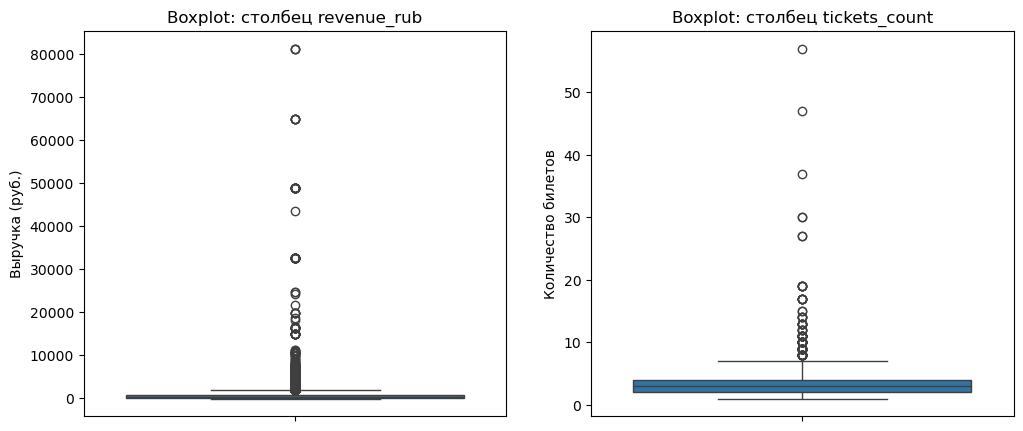

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(y=df['revenue_rub'], ax=axes[0])
axes[0].set_title('Boxplot: столбец revenue_rub')
axes[0].set_ylabel('Выручка (руб.)')


sns.boxplot(y=df['tickets_count'], ax=axes[1])
axes[1].set_title('Boxplot: столбец tickets_count')
axes[1].set_ylabel('Количество билетов')

plt.show()

Представленные гистограммы и диаграммы размаха подтверждают наличие выбросов.

In [97]:
df_old = df
revenue_99th = df['revenue_rub'].quantile(0.99)
df = df[df['revenue_rub'] <= revenue_99th]
print(f"Удалено строк: {len(df_old) - len(df)}")

Удалено строк: 2823


После фильтрации по 99-му перцентилю:
count    287788.000000
mean        518.050079
std         512.005422
min         -90.760000
25%         111.850000
50%         343.967790
75%         788.660000
max        2629.373070
Name: revenue_rub, dtype: float64


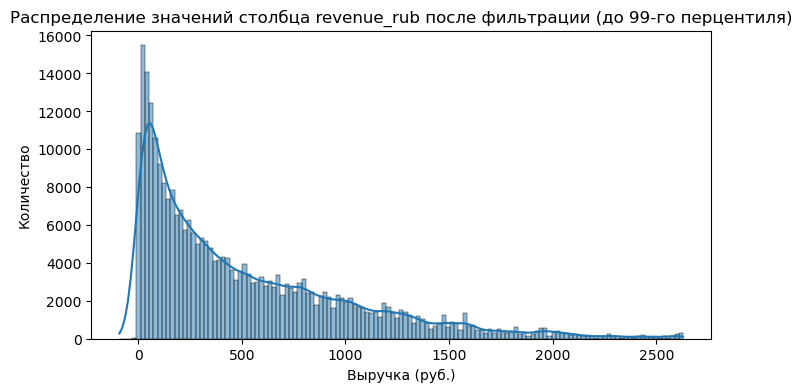

In [98]:
print("После фильтрации по 99-му перцентилю:")
print(df['revenue_rub'].describe())


plt.figure(figsize=(8, 4))
sns.histplot(df['revenue_rub'], kde=True)
plt.title('Распределение значений столбца revenue_rub после фильтрации (до 99-го перцентиля)')
plt.ylabel('Количество')
plt.xlabel('Выручка (руб.)')
plt.show()

In [99]:
df_old = df
revenue_99th = df['tickets_count'].quantile(0.99)
df = df[df['tickets_count'] <= revenue_99th]
print(f"Удалено строк: {len(df_old) - len(df)}")

Удалено строк: 180


После фильтрации по 99-му перцентилю:
count    287608.000000
mean          2.735647
std           1.136195
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           6.000000
Name: tickets_count, dtype: float64


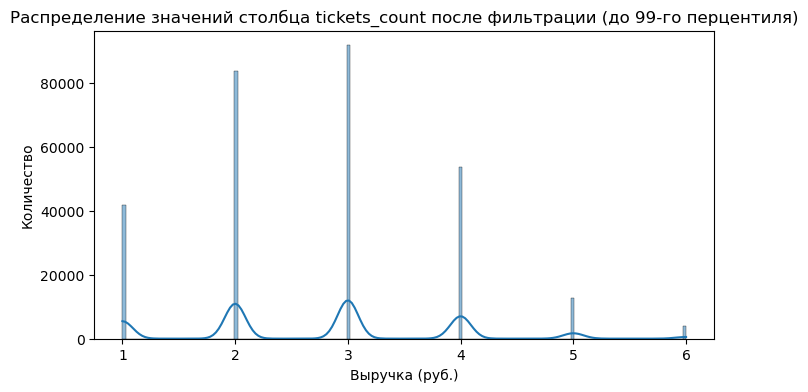

In [100]:
print("После фильтрации по 99-му перцентилю:")
print(df['tickets_count'].describe())


plt.figure(figsize=(8, 4))
sns.histplot(df['tickets_count'], kde=True)
plt.title('Распределение значений столбца tickets_count после фильтрации (до 99-го перцентиля)')
plt.ylabel('Количество')
plt.xlabel('Выручка (руб.)')
plt.show()

Далее рассмотрим столбцы с номинальными данными.

In [101]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,data,rate_per_tenge,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,2024-08-20,0.187,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион,2024-07-23,0.183,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион,2024-10-06,0.196,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область,2024-07-13,0.185,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край,2024-10-04,0.197,1390.41


In [102]:
print(df['device_type_canonical'].unique())
df['device_type_canonical'].nunique()

['mobile' 'desktop']


2

In [103]:
print(df['currency_code'].unique())
df['currency_code'].nunique()

['rub' 'kzt']


2

In [104]:
print(df['event_type_main'].unique())
df['event_type_main'].nunique()

['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']


7

In [105]:
print(df['service_name'].nunique())
df['service_name'].unique()

36


array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

In [106]:
print((df['city_name'].nunique()))
print(sorted(df['city_name'].unique()))

352
['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау', 'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск', 'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск', 'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград', 'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн', 'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск', 'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск', 'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво', 'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск', 'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес', 'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск', 'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград', 'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец', 'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк', 'Горноставинск', 'Горяново', 'Дальнеград', 'Дальнесветин', 'Дальнесветск', 'Дальнесоснов', 'Дальнозелен', 'Дальнозерск', 'Дальнозо

In [107]:
print(df['region_name'].nunique())
print(sorted(df['region_name'].unique()))

81
['Белоярская область', 'Берестовский округ', 'Берёзовская область', 'Боровлянский край', 'Верховинская область', 'Верхозёрский край', 'Верхоречная область', 'Ветренский регион', 'Вишнёвский край', 'Глиногорская область', 'Голубевский округ', 'Горицветская область', 'Горноземский регион', 'Горностепной регион', 'Дальнеземская область', 'Дальнезорский край', 'Дубравная область', 'Залесский край', 'Заречная область', 'Зеленоградский округ', 'Златопольский округ', 'Золотоключевской край', 'Зоринский регион', 'Каменевский регион', 'Каменичская область', 'Каменноозёрный край', 'Каменноярский край', 'Каменополянский округ', 'Ключеводский округ', 'Кристаловская область', 'Кристальная область', 'Крутоводская область', 'Крутоводский регион', 'Лесноярский край', 'Лесодальний край', 'Лесополянская область', 'Лесостепной край', 'Лесоярская область', 'Луговая область', 'Лугоградская область', 'Малиновая область', 'Малиновоярский округ', 'Медовская область', 'Миропольская область', 'Нежинская обла

In [108]:
print(df.duplicated().sum())

0


In [109]:
df['service_name'] = df['service_name'].str.strip()          
df['service_name'] = df['service_name'].str.lower()   
df['service_name'] = df['service_name'].str.replace(r'\s+', ' ', regex=True) 
print(df['service_name'].nunique())
df['service_name'].unique()

C:\Users\HOME\AppData\Local\Temp\ipykernel_876\4164221140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['service_name'] = df['service_name'].str.strip()
C:\Users\HOME\AppData\Local\Temp\ipykernel_876\4164221140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['service_name'] = df['service_name'].str.lower()


36


C:\Users\HOME\AppData\Local\Temp\ipykernel_876\4164221140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['service_name'] = df['service_name'].str.replace(r'\s+', ' ', regex=True)


array(['край билетов', 'мой билет', 'за билетом!', 'лови билет!',
       'билеты без проблем', 'облачко', 'лучшие билеты', 'прачечная',
       'быстробилет', 'дом культуры', 'весь в билетах', 'билеты в руки',
       'тебе билет!', 'show_ticket', 'городской дом культуры', 'яблоко',
       'билет по телефону', 'выступления.ру', 'росбилет',
       'шоу начинается!', 'мир касс', 'восьмёрка', 'телебилет',
       'crazy ticket!', 'реестр', 'быстрый кассир', 'карандашру',
       'радио ticket', 'дырокол', 'вперёд!', 'кино билет', 'цвет и билет',
       'зе бест!', 'тех билет', 'лимоны', 'билеты в интернете'],
      dtype=object)

In [110]:
df['city_name'] = df['city_name'].str.strip()          
df['city_name'] = df['city_name'].str.lower()         
df['city_name'] = df['city_name'].str.replace(r'\s+', ' ', regex=True) 
print(df['city_name'].nunique())
df['city_name'].unique()

C:\Users\HOME\AppData\Local\Temp\ipykernel_876\1403367699.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city_name'] = df['city_name'].str.strip()
C:\Users\HOME\AppData\Local\Temp\ipykernel_876\1403367699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['city_name'] = df['city_name'].str.lower()
C:\Users\HOME\AppData\Local\Temp\ipykernel_876\1403367699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

352


array(['глиногорск', 'озёрск', 'родниковецк', 'кристалевск',
       'дальнозолотск', 'радужнополье', 'радужсвет', 'кумсай',
       'верховино', 'светополье', 'кокжар', 'каменский', 'лесоярич',
       'никольянов', 'речинцево', 'лесозолотск', 'дальнозерск',
       'серебрянка', 'островецк', 'родниковец', 'дальнесветск',
       'луговаярово', 'ягодиновка', 'дальнополин', 'солчелуг', 'озёрчане',
       'серебровино', 'лесоярово', 'глинополье', 'глиноград',
       'дальнесветин', 'северополье', 'теплоозеро', 'горнодолинск',
       'ордакент', 'озёрово', 'луговинск', 'лугоград', 'златопольск',
       'крутовинск', 'сарыжар', 'сосновечин', 'тихоярск', 'яблонецк',
       'жаркентай', 'широковка', 'синеводов', 'синеводск', 'тихосветск',
       'радужанов', 'каменосветск', 'глиногорь', 'родниковск',
       'травогород', 'глинянск', 'радужинск', 'поляногорье',
       'дальнолесье', 'ручейник', 'ключеград', 'ключеводск', 'поленовино',
       'речичанск', 'ключевополье', 'шаныртау', 'дальнесоснов'

In [111]:
df['region_name'] = df['region_name'].str.strip()         
df['region_name'] = df['region_name'].str.lower()       
df['region_name'] = df['region_name'].str.replace(r'\s+', ' ', regex=True) 
print(df['region_name'].nunique())
df['region_name'].unique()

C:\Users\HOME\AppData\Local\Temp\ipykernel_876\1909469273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region_name'] = df['region_name'].str.strip()
C:\Users\HOME\AppData\Local\Temp\ipykernel_876\1909469273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region_name'] = df['region_name'].str.lower()


81


C:\Users\HOME\AppData\Local\Temp\ipykernel_876\1909469273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region_name'] = df['region_name'].str.replace(r'\s+', ' ', regex=True)


array(['каменевский регион', 'североярская область', 'озернинский край',
       'лугоградская область', 'поленовский край', 'широковская область',
       'медовская область', 'златопольский округ', 'малиновоярский округ',
       'яблоневская область', 'ветренский регион', 'боровлянский край',
       'крутоводская область', 'ягодиновская область',
       'серебряноярский округ', 'лесодальний край', 'верхоречная область',
       'горицветская область', 'речиновская область', 'травиницкий округ',
       'сосновская область', 'серебринская область', 'травяная область',
       'каменноярский край', 'солнечноземская область',
       'светополянский округ', 'заречная область', 'ручейковский край',
       'глиногорская область', 'тепляковская область',
       'каменноозёрный край', 'солнечнореченская область',
       'зоринский регион', 'берёзовская область', 'лесостепной край',
       'малиновая область', 'синегорский регион', 'луговая область',
       'шанырский регион', 'каменополянский окр

После проведения фильтрации значений столбца `revenue_rub` были удалены 2823 строки (что ни сильно скажется на итог, поскольку они составляют ~1% от общего количества строк), столбца `tickets_count` были удалены 188 строк (что тоже незначительно скажется на итоге), а максимальным значением стало значение 2629.37 руб. и  6 штук, соответственно.

Также были изучены уникальные значения номинальных данных. Ни один из столбцов с номинальными данными не требует нормализации и будут оставлены без изменения.

Явных и неявных дубликатов не обнаружено.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Численные признаки изучены, удалены выбросы.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Не выполнен анализ категориальных признаков:

    Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    
Тут нужно изучить уникальные значения ключевых категориальных признаков, задействованных в проекте, и сделать вывод о необходимости нормализации.

Также стоит проверить дубликаты.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [112]:
df = df.sort_values(['user_id', 'order_dt']).reset_index(drop=True)

In [113]:
user_profile = df.groupby('user_id').agg(
    first_order_date=('order_dt', 'min'),     
    last_order_date=('order_dt', 'max'),       
    total_orders=('order_id', 'count'),           
    total_revenue=('revenue_rub', 'sum'), 
    total_tickets=('tickets_count', 'sum'),
    avg_time=('days_since_prev', 'mean')
).reset_index()

In [114]:
first_order = df.drop_duplicates('user_id', keep='first').copy()

user_profile = user_profile.merge(
    first_order[['user_id', 
                 'device_type_canonical',
                 'region_name',
                 'service_name',
                 'event_type_main']],
    on='user_id',
    how='left'
)

In [115]:
user_profile['avg_revenue_per_order'] = user_profile['total_revenue'] / user_profile['total_orders']
user_profile['avg_tickets_per_order'] = user_profile['total_tickets'] / user_profile['total_orders']

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Разница между событиями уже посчитана в `days_since_prev` - руками её пересчитывать не нужно, стоит применить `mean` к уже готовому признаку.

In [116]:
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Профиль пользователя создан, бинарные метки добавлены.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [117]:
total_users = len(user_profile)

avg_revenue_per_order = user_profile['avg_revenue_per_order'].mean()

share_two_plus = (user_profile['is_two'].sum() / total_users) * 100  

share_five_plus = (user_profile['is_five'].sum() / total_users) * 100  

print(f"Общее число пользователей: {total_users}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:.2f} руб.")
print(f"Доля пользователей с 2+ заказами: {share_two_plus:.1f}%")
print(f"Доля пользователей с 5+ заказами: {share_five_plus:.1f}%")

Общее число пользователей: 21847
Средняя выручка с одного заказа: 544.18 руб.
Доля пользователей с 2+ заказами: 61.7%
Доля пользователей с 5+ заказами: 29.0%


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Тут и далее для оценки доли можно применять `mean` к бинарным признакам.

In [118]:
orders_stats = user_profile['total_orders'].describe()
print(orders_stats.apply(lambda x: f"{x:.2f}" if isinstance(x, float) else x))

count    21847.00
mean        13.16
std        121.58
min          1.00
25%          1.00
50%          2.00
75%          5.00
max      10168.00
Name: total_orders, dtype: object


Есть выбросы в столбце `total_orders`, судя по значению max - 10168 (значение mean при этом - 13).

In [119]:
tickets_stats = user_profile['avg_tickets_per_order'].describe()
print(tickets_stats.apply(lambda x: f"{x:.2f}" if isinstance(x, float) else x))

count    21847.00
mean         2.74
std          0.90
min          1.00
25%          2.00
50%          2.75
75%          3.07
max          6.00
Name: avg_tickets_per_order, dtype: object


Выбросов в столбце `avg_tickets_per_order` не замечено.

In [120]:
interval_stats = user_profile['avg_time'].describe()
print(interval_stats.apply(lambda x: f"{x:.2f}" if isinstance(x, float) else x))

count    13509.00
mean        15.84
std         22.29
min          0.00
25%          1.00
50%          8.00
75%         20.33
max        148.00
Name: avg_time, dtype: object


Рассмотрим столбец `total_orders`  с явными выбросами.

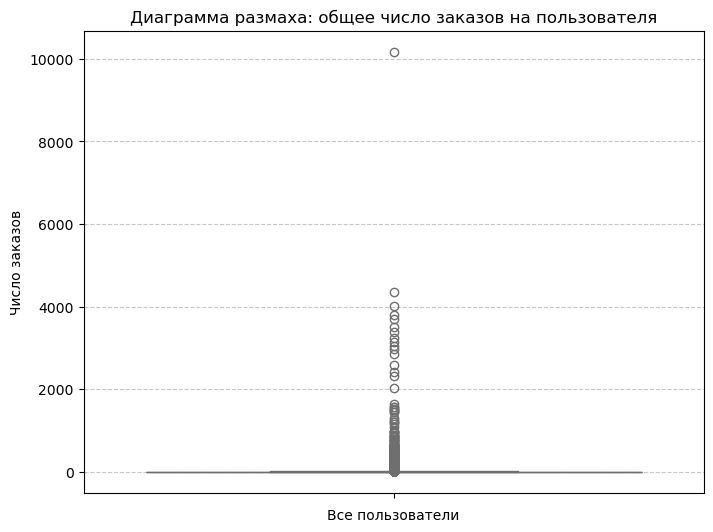

In [121]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=user_profile['total_orders'], color='skyblue')
plt.title('Диаграмма размаха: общее число заказов на пользователя')
plt.ylabel('Число заказов')
plt.xlabel('Все пользователи')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [122]:
revenue_95th = user_profile['total_orders'].quantile(0.95)
print(user_profile[user_profile['total_orders'] > revenue_95th].shape)

(1092, 15)


При фильтрации по столбцу `total_orders` по 95-перцентилю будут удалены 1092 строки (~5% от общего числва всех строк в `user_profile`, что в целом не скажется на результате.

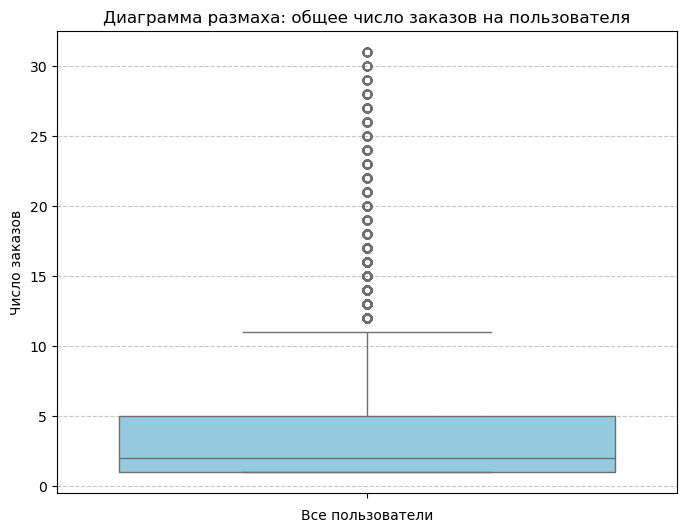

In [123]:
user_profile = user_profile[user_profile['total_orders'] <= revenue_95th]
plt.figure(figsize=(8, 6))
sns.boxplot(y= user_profile['total_orders'], color='skyblue')
plt.title('Диаграмма размаха: общее число заказов на пользователя')
plt.ylabel('Число заказов')
plt.xlabel('Все пользователи')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [124]:
orders_statsss = user_profile['total_orders'].describe()
print(orders_statsss.apply(lambda x: f"{x:.2f}" if isinstance(x, float) else x))

count    20755.00
mean         4.05
std          5.11
min          1.00
25%          1.00
50%          2.00
75%          5.00
max         31.00
Name: total_orders, dtype: object


По итогу осталось 20755 строк в `user_profile`, максимальное стало 31.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Статистики по профилю пользователя изучены, удалены выбросы.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [125]:
def analyze_categorical_distribution(df, column, total_users):
    grouped = df[column].value_counts().reset_index()
    grouped.columns = [column, 'count']
    
    grouped['share_%'] = round((grouped['count'] / total_users) * 100, 2)
    
    grouped = grouped.sort_values('count', ascending=False).reset_index(drop=True)
    
    return grouped

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> По небинарным признакам доли удобнее считать через `value_counts(normalize=True)`.

In [126]:
total_users = len(user_profile)

segments_by_event = analyze_categorical_distribution(user_profile, 'event_type_main', total_users)
segments_by_device = analyze_categorical_distribution(user_profile, 'device_type_canonical', total_users)
segments_by_region = analyze_categorical_distribution(user_profile, 'region_name', total_users)
segments_by_service = analyze_categorical_distribution(user_profile, 'service_name', total_users)

In [127]:
segments_by_region = segments_by_region.head(5)
segments_by_service = segments_by_service.head(5)

print(segments_by_event.to_string(index=False))

print(f"\n{segments_by_device.to_string(index=False)}")

print(f"\n{segments_by_region.to_string(index=False)}")

print(f"\n{segments_by_service.to_string(index=False)}")

event_type_main  count  share_%
       концерты   9194    44.30
         другое   5162    24.87
          театр   4073    19.62
        стендап   1073     5.17
          спорт    765     3.69
       выставки    396     1.91
           ёлки     92     0.44

device_type_canonical  count  share_%
               mobile  17196    82.85
              desktop   3559    17.15

         region_name  count  share_%
  каменевский регион   6778    32.66
североярская область   3593    17.31
 широковская область   1190     5.73
    озернинский край    659     3.18
малиновоярский округ    510     2.46

      service_name  count  share_%
билеты без проблем   4954    23.87
         мой билет   2854    13.75
       лови билет!   2720    13.11
     билеты в руки   2421    11.66
           облачко   2108    10.16


C:\Users\HOME\AppData\Local\Temp\ipykernel_876\2577561444.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segments_by_event, x='event_type_main', y='count', ax=axes[0,0], palette='viridis')
C:\Users\HOME\AppData\Local\Temp\ipykernel_876\2577561444.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segments_by_device, x='device_type_canonical', y='count', ax=axes[0,1], palette='coolwarm')
C:\Users\HOME\AppData\Local\Temp\ipykernel_876\2577561444.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segments_by_region, x='r

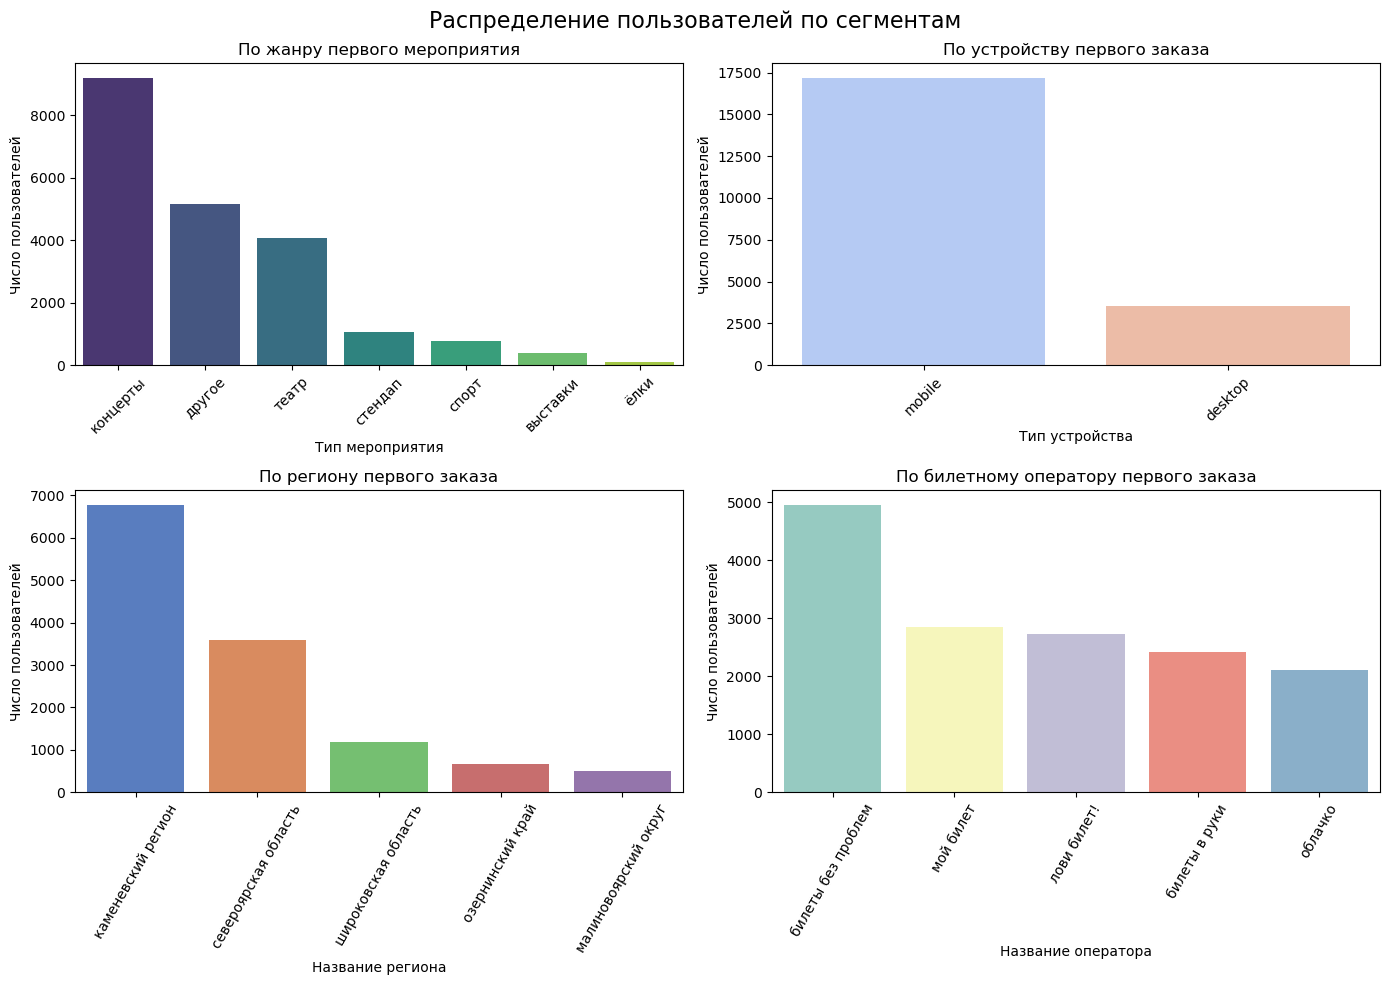

In [128]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Распределение пользователей по сегментам", fontsize=16)


sns.barplot(data=segments_by_event, x='event_type_main', y='count', ax=axes[0,0], palette='viridis')
axes[0,0].set_title("По жанру первого мероприятия")
axes[0,0].set_ylabel("Число пользователей")
axes[0,0].set_xlabel("Тип мероприятия")
axes[0,0].tick_params(axis='x', rotation=45)



sns.barplot(data=segments_by_device, x='device_type_canonical', y='count', ax=axes[0,1], palette='coolwarm')
axes[0,1].set_title("По устройству первого заказа")
axes[0,1].set_ylabel("Число пользователей")
axes[0,1].set_xlabel("Тип устройства")
axes[0,1].tick_params(axis='x', rotation=45)


sns.barplot(data=segments_by_region, x='region_name', y='count', ax=axes[1,0], palette='muted')
axes[1,0].set_title("По региону первого заказа")
axes[1,0].set_ylabel("Число пользователей")
axes[1,0].set_xlabel("Название региона")
axes[1,0].tick_params(axis='x', rotation=60)



sns.barplot(data=segments_by_service, x='service_name', y='count', ax=axes[1,1], palette='Set3')
axes[1,1].set_title("По билетному оператору первого заказа")
axes[1,1].set_ylabel("Число пользователей")
axes[1,1].set_xlabel("Название оператора")
axes[1,1].tick_params(axis='x', rotation=60)


plt.tight_layout()
plt.show()

Среди различных сегментов можно заметить, что все 4 выделенных сегмента имеют по одному представителю сильно отличающийся от всех остальных в пределах данного сегмента:
1. По жанру особо выделяются ***концерты***
2. По устройству - ***mobile***
3. По региону - ***Каменевский регион***
4. По билетному оператору - ***Билеты без проблем***

Это все может говорить о том, что в каждом из сегментов, вероятно, есть выраженные «точки входа».

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Твой анализ выполнен абсолютно верно. Ты правильно ответил на главный вопрос задачи: распределение пользователей действительно неравномерное. Ты также безошибочно определил по одному самому крупному сегменту, или "точке входа", в каждой из четырех категорий. Все четыре лидера, которых ты перечислил - концерты, mobile, Каменевский регион и Билеты без проблем - полностью соответствуют данным из таблицы.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Твой вывод о том, что в каждом сегменте есть один сильно отличающийся представитель, можно немного уточнить. Это абсолютно верно для жанров, устройств и регионов, где лидеры (концерты, mobile, Каменевский регион) имеют подавляющее преимущество. Однако в сегменте билетных операторов, хоть Билеты без проблем и лидирует, следующие четыре оператора тоже держат очень значимые доли (от 10% до 13% каждый). Здесь концентрация не так сильно выражена на одном лидере, как в других категориях.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [129]:
def calculate_two_plus_share(df, group_col):
    grouped = df.groupby(group_col).agg(
        total_users=('user_id', 'count'),
        two_plus_count=('is_two', 'sum')
    ).reset_index()
    grouped['two_plus_share_%'] = (grouped['two_plus_count'] / grouped['total_users']) * 100
    grouped = grouped.sort_values('total_users', ascending=False).reset_index(drop=True)
    return grouped

In [130]:
seg_event = calculate_two_plus_share(user_profile, 'event_type_main')
seg_device = calculate_two_plus_share(user_profile, 'device_type_canonical')
seg_region = calculate_two_plus_share(user_profile, 'region_name')
seg_service = calculate_two_plus_share(user_profile, 'service_name')

In [131]:
seg_region_top10 = seg_region.head(10)
seg_service_top10 = seg_service.head(10)

C:\Users\HOME\AppData\Local\Temp\ipykernel_876\2935761059.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seg_event_sorted, x='event_type_main', y='two_plus_share_%', ax=axes[0,0], palette='Blues')
C:\Users\HOME\AppData\Local\Temp\ipykernel_876\2935761059.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seg_device_sorted, x='device_type_canonical', y='two_plus_share_%', ax=axes[0,1], palette='Greens')
C:\Users\HOME\AppData\Local\Temp\ipykernel_876\2935761059.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seg_regi

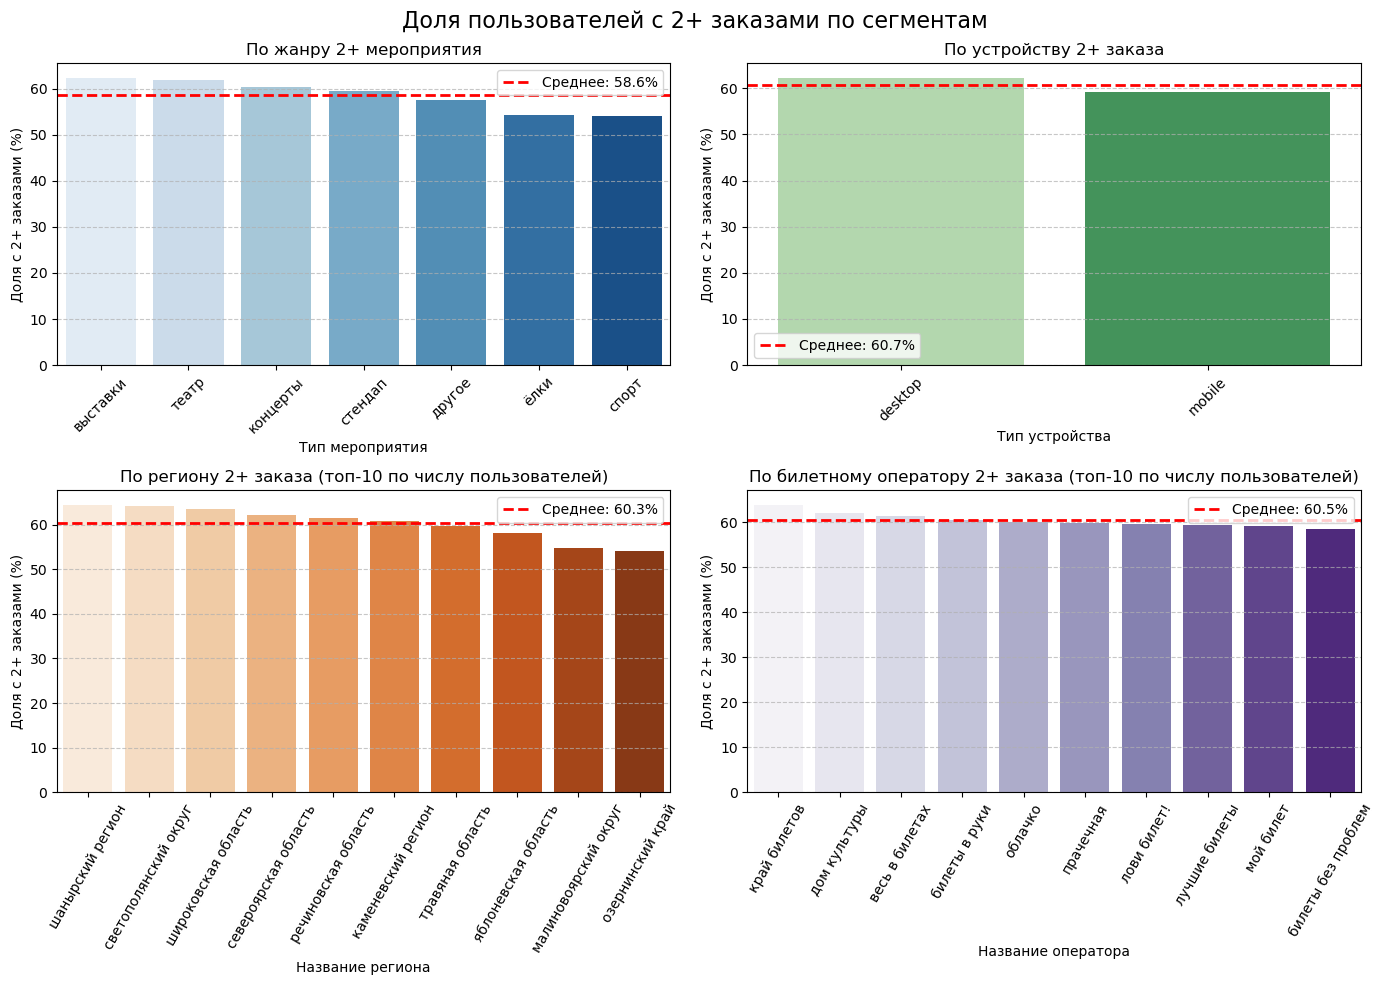

In [132]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Доля пользователей с 2+ заказами по сегментам", fontsize=16)


seg_event_sorted = seg_event.sort_values('two_plus_share_%', ascending=False)
mean_event = seg_event['two_plus_share_%'].mean()  
sns.barplot(data=seg_event_sorted, x='event_type_main', y='two_plus_share_%', ax=axes[0,0], palette='Blues')
axes[0,0].set_title("По жанру 2+ мероприятия")
axes[0,0].set_ylabel("Доля с 2+ заказами (%)")
axes[0,0].set_xlabel("Тип мероприятия")
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].axhline(mean_event, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_event:.1f}%')
axes[0,0].legend()

seg_device_sorted = seg_device.sort_values('two_plus_share_%', ascending=False)
mean_device = seg_device['two_plus_share_%'].mean()  
sns.barplot(data=seg_device_sorted, x='device_type_canonical', y='two_plus_share_%', ax=axes[0,1], palette='Greens')
axes[0,1].set_title("По устройству 2+ заказа")
axes[0,1].set_ylabel("Доля с 2+ заказами (%)")
axes[0,1].set_xlabel("Тип устройства")
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(mean_device, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_device:.1f}%')
axes[0,1].legend()



seg_region_top10_sorted = seg_region_top10.sort_values('two_plus_share_%', ascending=False)
mean_region = seg_region_top10['two_plus_share_%'].mean() 
sns.barplot(data=seg_region_top10_sorted, x='region_name', y='two_plus_share_%', ax=axes[1,0], palette='Oranges')
axes[1,0].set_title("По региону 2+ заказа (топ-10 по числу пользователей)")
axes[1,0].set_ylabel("Доля с 2+ заказами (%)")
axes[1,0].set_xlabel("Название региона")
axes[1,0].tick_params(axis='x', rotation=60)
axes[1,0].axhline(mean_region, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_region:.1f}%')
axes[1,0].legend()


seg_service_top10_sorted = seg_service_top10.sort_values('two_plus_share_%', ascending=False)
mean_service = seg_service_top10['two_plus_share_%'].mean()  
sns.barplot(data=seg_service_top10_sorted, x='service_name', y='two_plus_share_%', ax=axes[1,1], palette='Purples')
axes[1,1].set_title("По билетному оператору 2+ заказа (топ-10 по числу пользователей)")
axes[1,1].set_ylabel("Доля с 2+ заказами (%)")
axes[1,1].set_xlabel("Название оператора")
axes[1,1].tick_params(axis='x', rotation=60)
axes[1,1].axhline(mean_service, color='red', linestyle='--', linewidth=2, label=f'Среднее: {mean_service:.1f}%')
axes[1,1].legend()


for ax in axes.flat:
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> На графики этого типа стоит добавлять `axhline` со средним уровнем возврата для более визуального выделения точек входа.

При анализе сегментов сложно было выделить какого-то одного "лидера", поскольку в каждом сегменте все представители имеют примерно равные доли (~60%).

Наблюдаются сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке:
- по жанру: выставки, театр, концерты, и стендап
- по устройству: desktop
- по региону: Шанырский, Светополянский, ШироковскаяЮ, Североярская, Речиновская области
- по оператору: край билетов, дом культуры и вессь в билетах

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты выполнил часть задачи и построил визуализации для четырех сегментов, как и требовалось. На графиках отображена доля пользователей, совершивших 2 и более заказа, что соответствует заданию.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Твой текстовый вывод комментирует только один из четырех графиков - по типу устройства. Анализ по жанрам, регионам и операторам, который также требовался, отсутствует. Кроме того, ты утверждаешь, что разница между desktop и mobile "значительная", хотя на графике она выглядит минимальной, столбики почти одинаковой высоты.
    
Твой вывод ("далее пользователи делают чаще заказ на desktop устройствах") содержит ошибку в интерпретации данных. Графики показывают долю возврата (вероятность совершить 2+ заказа) в зависимости от устройства первого заказа. Они не предоставляют никакой информации о том, на каких устройствах пользователи совершают последующие заказы. Ты путаешь "долю вернувшихся" с "предпочтениями при втором заказе".

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [133]:
try:
    sport_share = seg_event.loc[seg_event['event_type_main'] == 'спорт', 'two_plus_share_%'].values[0]
    concert_share = seg_event.loc[seg_event['event_type_main'] == 'концерты', 'two_plus_share_%'].values[0]
    
    print(f"Доля повторных заказов (спорт): {sport_share:.2f}%")
    print(f"Доля повторных заказов (концерт): {concert_share:.2f}%")
    
    if sport_share > concert_share:
        print("Гипотеза 1 ПОДТВЕРЖДЕНА: спортивные пользователи возвращаются чаще.")
    elif sport_share < concert_share:
        print("Гипотеза 1 НЕ ПОДТВЕРЖДЕНА: концертные пользователи возвращаются чаще.")
    else:
        print("Гипотеза 1 НЕ ОПРЕДЕЛЕНА: доли равны.")
except IndexError:
    print("Не найдены категории 'Спорт' или 'Концерт' в данных.")

Доля повторных заказов (спорт): 54.12%
Доля повторных заказов (концерт): 60.31%
Гипотеза 1 НЕ ПОДТВЕРЖДЕНА: концертные пользователи возвращаются чаще.


In [134]:
top_5_regions = seg_region.head(5)['region_name'].tolist()

top_group = seg_region[seg_region['region_name'].isin(top_5_regions)]
other_group = seg_region[~seg_region['region_name'].isin(top_5_regions)]


mean_top = top_group['two_plus_share_%'].mean()
mean_other = other_group['two_plus_share_%'].mean()

print(f"\nСредняя доля повторных заказов в топ‑5 регионах: {mean_top:.2f}%")
print(f"Средняя доля повторных заказов в остальных регионах: {mean_other:.2f}%")


if mean_top > mean_other:
    print("Гипотеза 2 ПОДТВЕРЖДЕНА: в активных регионах доля повторных заказов выше.")
elif mean_top < mean_other:
    print("Гипотеза 2 НЕ ПОДТВЕРЖДЕНА: в менее активных регионах доля выше.")
else:
    print("Гипотеза 2 НЕ ОПРЕДЕЛЕНА: средние доли равны.")


Средняя доля повторных заказов в топ‑5 регионах: 59.03%
Средняя доля повторных заказов в остальных регионах: 53.11%
Гипотеза 2 ПОДТВЕРЖДЕНА: в активных регионах доля повторных заказов выше.


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Гипотезы проверены корректно.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Признак уже был посчитан ранее - повторно добавлять не нужно.

In [135]:
one_order = user_profile[user_profile['is_two'] == 0]  
two_plus_orders = user_profile[user_profile['is_two'] == 1]  

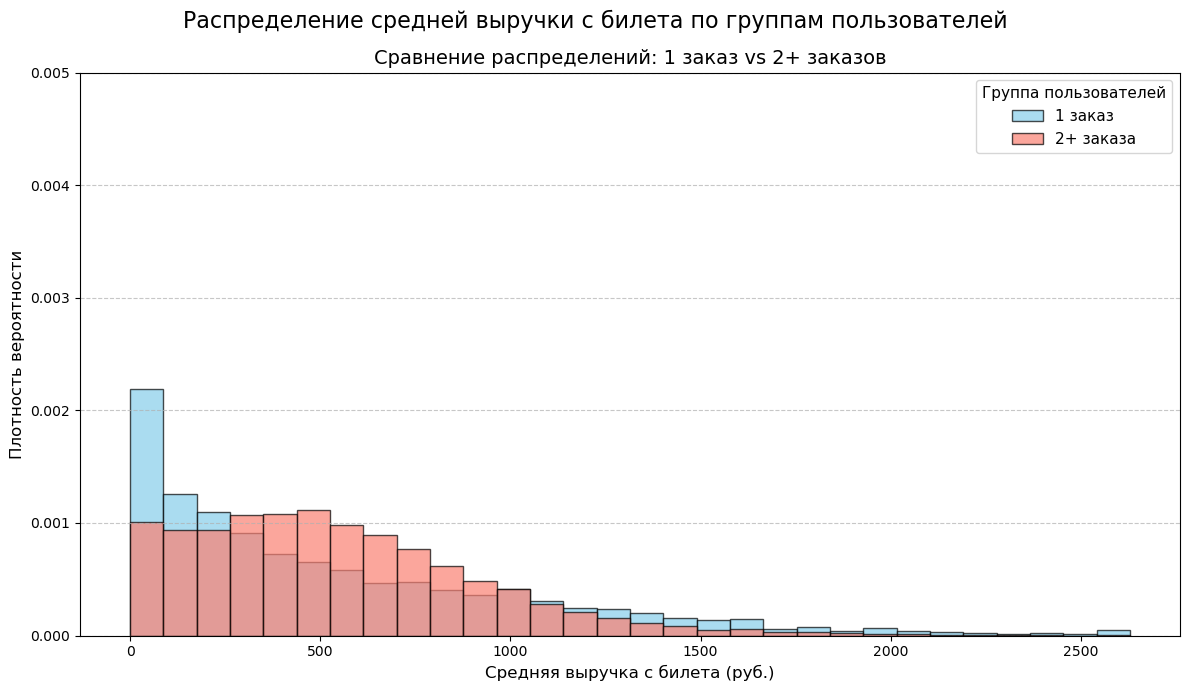

In [136]:
bins = 30
bin_range = (0, max(
    one_order['avg_revenue_per_order'].max(),
    two_plus_orders['avg_revenue_per_order'].max()
))

fig, ax = plt.subplots(figsize=(12, 7))
fig.suptitle("Распределение средней выручки с билета по группам пользователей", fontsize=16)

ax.hist(
    one_order['avg_revenue_per_order'],
    bins=bins,
    range=bin_range,
    color='skyblue',
    alpha=0.7,
    edgecolor='black',
    density=True,
    label='1 заказ'
)

ax.hist(
    two_plus_orders['avg_revenue_per_order'],
    bins=bins,
    range=bin_range,
    color='salmon',
    alpha=0.7,
    edgecolor='black',
    density=True,
    label='2+ заказа'
)

ax.set_xlabel("Средняя выручка с билета (руб.)", fontsize=12)
ax.set_ylabel("Плотность вероятности", fontsize=12)  # т.к. density=True

ax.set_title("Сравнение распределений: 1 заказ vs 2+ заказов", fontsize=14)
ax.legend(title="Группа пользователей", fontsize=11, title_fontsize=11)

ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.set_ylim(0, 0.005)

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Графики стоит наложить друг на друга для более наглядного сравнения сегментов. Не забудь про параметры нормирования.

Смотря на гистограммы, можно заметить, что значения средней выручки пользователей из первой группы (1 заказом) концентрируются в диапазоне от 0 до 200, в то время как значения из второй группы - ~200-700.\
В целом различия в значениях между этими группами состоит в том, что у первой гурппы максимум пользователей приходится на среднюю выручку за билет 0-100 руб., а у второй группы - 150-250 руб.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b>  Задача выполнена: ты построил сравнительные гистограммы и блоксплот, которые наглядно показывают разницу между группами. Твой вывод во второй части (где говорится о пиках) абсолютно верный. Ты правильно определил, что у пользователей с 1 заказом максимум концентрации приходится на очень низкие чеки (0-100 рублей), в то время как у группы 2+ заказов этот пик смещен вправо, в диапазон 150-250 рублей.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Вывод, основанный на средних значениях (199.26 руб. против 200.87 руб.), хотя и технически верный (200.87 действительно больше 199.26), немного смазывает общую картину, так как разница выглядит незначительной. Гистограммы и блоксплот, которые ты также приводишь, показывают более существенное различие в "типичном" чеке (медиане), и это более важное наблюдение.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Первое предложение твоего основного текстового анализа (где сравниваются диапазоны 0-500 и 0-400) сформулировано некорректно и вводит в заблуждение. Из него можно сделать вывод, что у группы 2+ заказов диапазон концентрации ниже (0-400), чем у группы с 1 заказом (0-500). Это прямо противоречит графикам, которые ясно показывают, что распределение для группы 2+ смещено вправо, в сторону более высоких значений, а не более низких.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


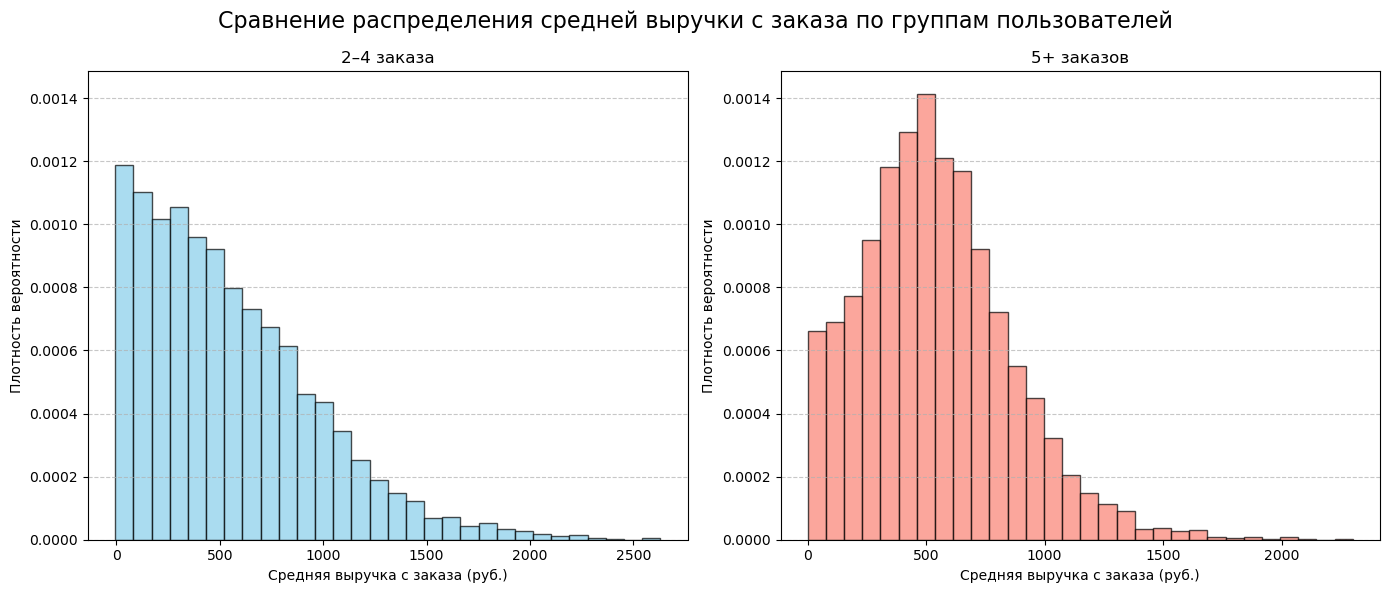

In [137]:
group_2to4 = user_profile[(user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)]
group_5plus = user_profile[user_profile['total_orders'] >= 5]


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Сравнение распределения средней выручки с заказа по группам пользователей", fontsize=16)

axes[0].hist(
    group_2to4['avg_revenue_per_order'],
    bins=30,
    color='skyblue',
    alpha=0.7,
    edgecolor='black',
    density=True 
)
axes[0].set_title("2–4 заказа")
axes[0].set_xlabel("Средняя выручка с заказа (руб.)")
axes[0].set_ylabel("Плотность вероятности")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)



axes[1].hist(
    group_5plus['avg_revenue_per_order'],
    bins=30,
    color='salmon',
    alpha=0.7,
    edgecolor='black',
    density=True 
)
axes[1].set_title("5+ заказов")
axes[1].set_xlabel("Средняя выручка с заказа (руб.)")
axes[1].set_ylabel("Плотность вероятности")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)



y_max_common = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, y_max_common)
axes[1].set_ylim(0, y_max_common)


plt.tight_layout()
plt.show()


Различия между двумя этими группами состоят в том, что пользлователи делали от 2 до 4 в основном дешевых заказов (с низкой выручкой), а те пользователи, которые делали 5+ заказов платили в среднем 500 руб.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Твой вывод о том, что эти различия есть, абсолютно верный. Ты правильно определил, что у группы 2–4 заказа пик приходится на "дешевые заказы" (низкую выручку), в то время как у группы 5+ заказов пик смещен вправо, в район 500 рублей. Это в точности соответствует тому, что показано на графиках.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [138]:
bins = [1, 2, 3, 5, float('inf')]
labels = ['1–2 билета', '2–3 билета', '3–5 билетов', '5+ билетов']


user_profile['ticket_segment'] = pd.cut(
   user_profile['avg_tickets_per_order'],
    bins=bins,
    labels=labels,
    right=False 
)

In [139]:
segment_analysis = (
    user_profile
    .groupby('ticket_segment')
    .agg(
        total_users=('user_id', 'count'),
        repeat_buyers=('total_orders', lambda x: (x > 1).sum())
    )
    .reset_index()
)

segment_analysis['repeat_rate'] = (
    segment_analysis['repeat_buyers'] / segment_analysis['total_users']
)

segment_analysis['repeat_rate_pct'] = (
    segment_analysis['repeat_rate'].round(4) * 100
)

C:\Users\HOME\AppData\Local\Temp\ipykernel_876\3149572278.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('ticket_segment')


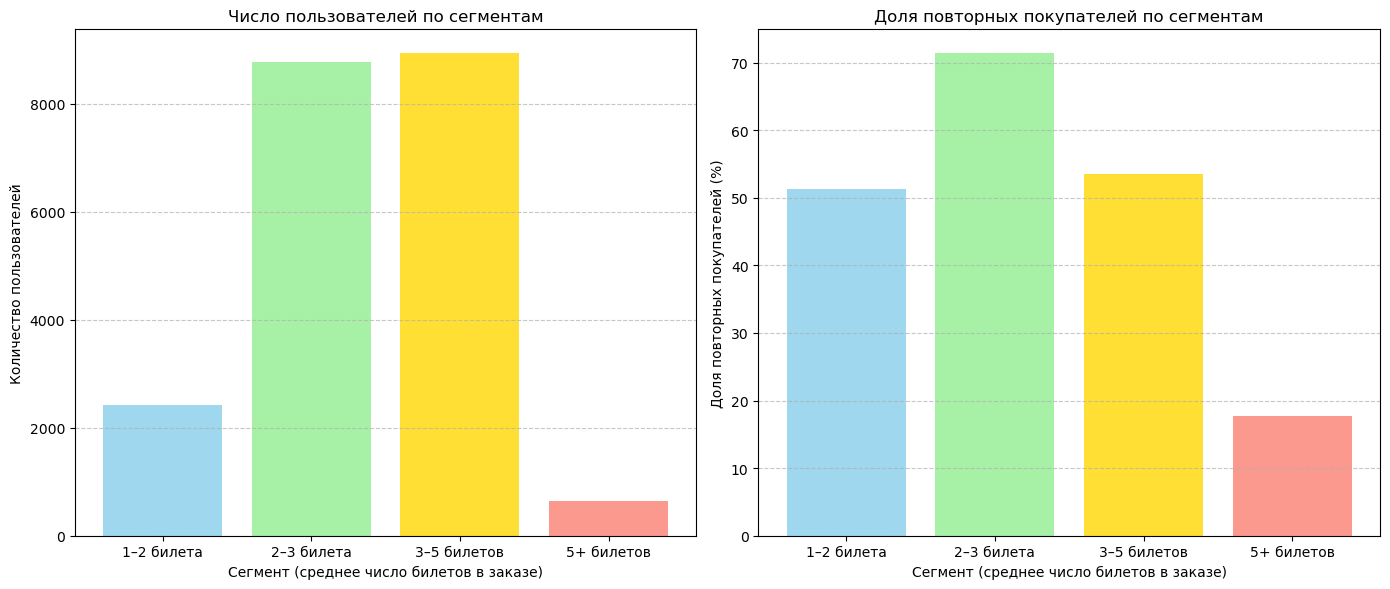

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))


ax1.bar(
    segment_analysis['ticket_segment'],
    segment_analysis['total_users'],
    color=['skyblue', 'lightgreen', 'gold', 'salmon'],
    alpha=0.8
)
ax1.set_title("Число пользователей по сегментам")
ax1.set_xlabel("Сегмент (среднее число билетов в заказе)")
ax1.set_ylabel("Количество пользователей")
ax1.grid(axis='y', linestyle='--', alpha=0.7)


ax2.bar(
    segment_analysis['ticket_segment'],
    segment_analysis['repeat_rate_pct'],
    color=['skyblue', 'lightgreen', 'gold', 'salmon'],
    alpha=0.8
)
ax2.set_title("Доля повторных покупателей по сегментам")
ax2.set_xlabel("Сегмент (среднее число билетов в заказе)")
ax2.set_ylabel("Доля повторных покупателей (%)")
ax2.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


Основную часть пользователей составляют те, кто покупал 2-5 билетов.\
Аномально высоким является сегмент 2-3 билета в том время, как аномально низким - сегмент 5+ билетов (>8000 пользователей в среднем и 70% от общей доли повторных покупателей, <2000 и ~20%, соответственно)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Ты правильно определил, что основная масса пользователей сконцентрирована в сегментах 2-3 билета и 3-5 билетов, что соответствует левому графику.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Ты утверждаешь, что сегмент 3-5 билетов также является "аномально высоким" с долей возврата 50%. На самом деле, на графике доля этого сегмента не является аномально высокой, она близка к сегменту 1-2 билета. Аномально низким является сегмент 5+ билетов. Таким образом, ты неверно определил второй аномальный сегмент.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [141]:
user_profile['first_order_date'] = pd.to_datetime(user_profile['first_order_date'])

user_profile['first_order_weekday'] = user_profile['first_order_date'].dt.weekday


days_of_week = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
user_profile['first_order_day'] = user_profile['first_order_weekday'].map(lambda x: days_of_week[x])

In [142]:
analysis = (
    user_profile
    .groupby('first_order_day')
    .agg(
        total_users=('user_id', 'count'),
        repeat_buyers=('total_orders', lambda x: (x > 1).sum())
    )
    .reset_index()
)

analysis['repeat_rate'] = analysis['repeat_buyers'] / analysis['total_users']
analysis['repeat_rate_pct'] = analysis['repeat_rate'].round(4) * 100


analysis['day_order'] = analysis['first_order_day'].map(
    {day: idx for idx, day in enumerate(days_of_week)}
)
analysis = analysis.sort_values('day_order').drop('day_order', axis=1)

In [143]:
print("Влияние дня недели первой покупки на повторные заказы")
print("=" * 60)
print(analysis[[
    'first_order_day', 
    'total_users',
    'repeat_buyers',
    'repeat_rate_pct'
]].to_string(index=False))
print("\n")

Влияние дня недели первой покупки на повторные заказы
first_order_day  total_users  repeat_buyers  repeat_rate_pct
    Понедельник         2819           1736            61.58
        Вторник         3027           1815            59.96
          Среда         2960           1803            60.91
        Четверг         3026           1764            58.29
        Пятница         3165           1856            58.64
        Суббота         3119           1884            60.40
    Воскресенье         2639           1530            57.98




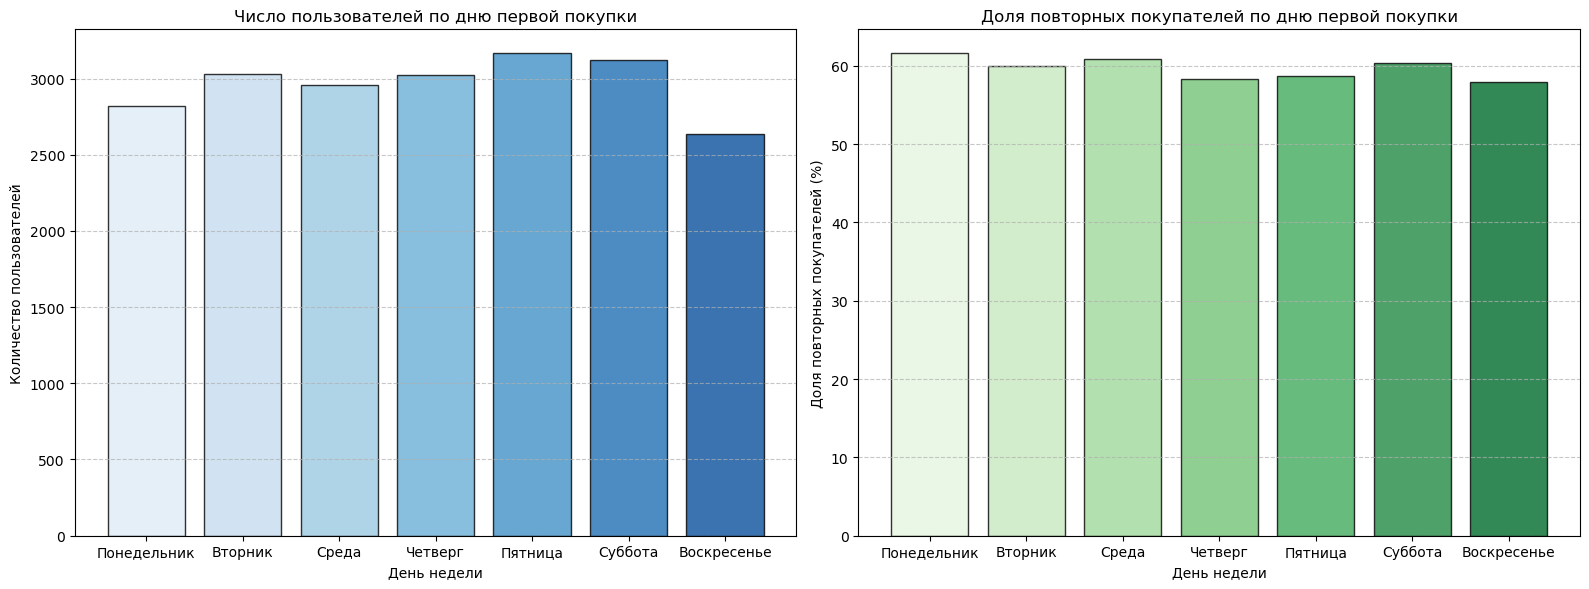

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.bar(
    analysis['first_order_day'],
    analysis['total_users'],
    color=sns.color_palette("Blues", 7),
    alpha=0.8,
    edgecolor='black'
)
ax1.set_title("Число пользователей по дню первой покупки")
ax1.set_xlabel("День недели")
ax1.set_ylabel("Количество пользователей")
ax1.grid(axis='y', linestyle='--', alpha=0.7)


ax2.bar(
    analysis['first_order_day'],
    analysis['repeat_rate_pct'],
    color=sns.color_palette("Greens", 7),
    alpha=0.8,
    edgecolor='black'
)
ax2.set_title("Доля повторных покупателей по дню первой покупки")
ax2.set_xlabel("День недели")
ax2.set_ylabel("Доля повторных покупателей (%)")
ax2.grid(axis='y', linestyle='--', alpha=0.7)



plt.tight_layout()
plt.show()

День недели не влияет на вероятность возврата клиента.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Твой итоговый вывод о том, что день недели первой покупки не влияет на вероятность возврата, в целом верный. Оба источника данных (и таблица, и графики) показывают, что все значения долей находятся в очень узком диапазоне.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Средний интервал уже должен быть посчитан в профиле пользователя - дублировать не нужно.

In [145]:
group_2to4 = user_profile[
    (user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)
]
group_5plus = user_profile[user_profile['total_orders'] >= 5]

avg_2to4 = group_2to4['avg_time'].mean()
avg_5plus = group_5plus['avg_time'].mean()

print(f"Среднее время между заказами (2–4 заказа): {avg_2to4:.2f} дней")
print(f"Среднее время между заказами (5+ заказов): {avg_5plus:.2f} дней")

Среднее время между заказами (2–4 заказа): 21.31 дней
Среднее время между заказами (5+ заказов): 11.12 дней


Полученные данные демонстрируют существенную разницу в частоте повторных покупок между двумя группами пользователей:
пользователи с 2–4 заказами совершают повторные покупки в среднем раз в 21,3 дня, в то время как пользователи с 5+ заказами — почти вдвое чаще: раз в 11,1 дня.

Значительно более короткое время между заказами указывает на либо на сформированную привычку покупать, либо на высокую вовлечённость в сервис.

А для группы «2–4 заказа», вероятней всего, покупки носят эпизодический характер (по необходимости, под акцию, от случая к случаю).

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Твой вывод о том, что пользователи с 5 и более заказами имеют значительно более короткий интервал между покупками (11.2 дня), чем менее лояльные группы (21.4 дня), полностью подтверждается данными. Интерпретации о "сформированной привычке" и "эпизодическом характере" также логичны.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [146]:
interval_cols = [
    'total_revenue',
    'avg_revenue_per_order',
    'avg_tickets_per_order',
    'total_tickets',
    'total_orders'
]

corr_phik_matrix = phik.phik_matrix(
    user_profile[interval_cols],
    interval_cols=interval_cols,
    bins=10  
)

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Ты прменяешь `phik_matrix` к уже посчитанной матрице корреляции Пирсона, фактически считая корреляции между корреляциями - действие бессмысленное. 
    
Нужно сразу применить `phik_matrix` к таблице с профилем пользователя, не забудь при этом настроить `interva_cols`, передав туда непрерывные признаки.

In [147]:
corr_phik_matrix.loc[corr_phik_matrix.index != 'total_orders'][['total_orders']].sort_values(by='total_orders', ascending=False)

,total_orders
total_tickets,0.920463
total_revenue,0.628223
avg_tickets_per_order,0.414446
avg_revenue_per_order,0.265618


In [148]:
# Получаем корреляции только с total_orders
corr_with_total_orders = corr_phik_matrix['total_orders'].sort_values(ascending=False)


print("Корреляция phi_k с total_orders:")
print(corr_with_total_orders)


Корреляция phi_k с total_orders:
total_orders             1.000000
total_tickets            0.920463
total_revenue            0.628223
avg_tickets_per_order    0.414446
avg_revenue_per_order    0.265618
Name: total_orders, dtype: float64


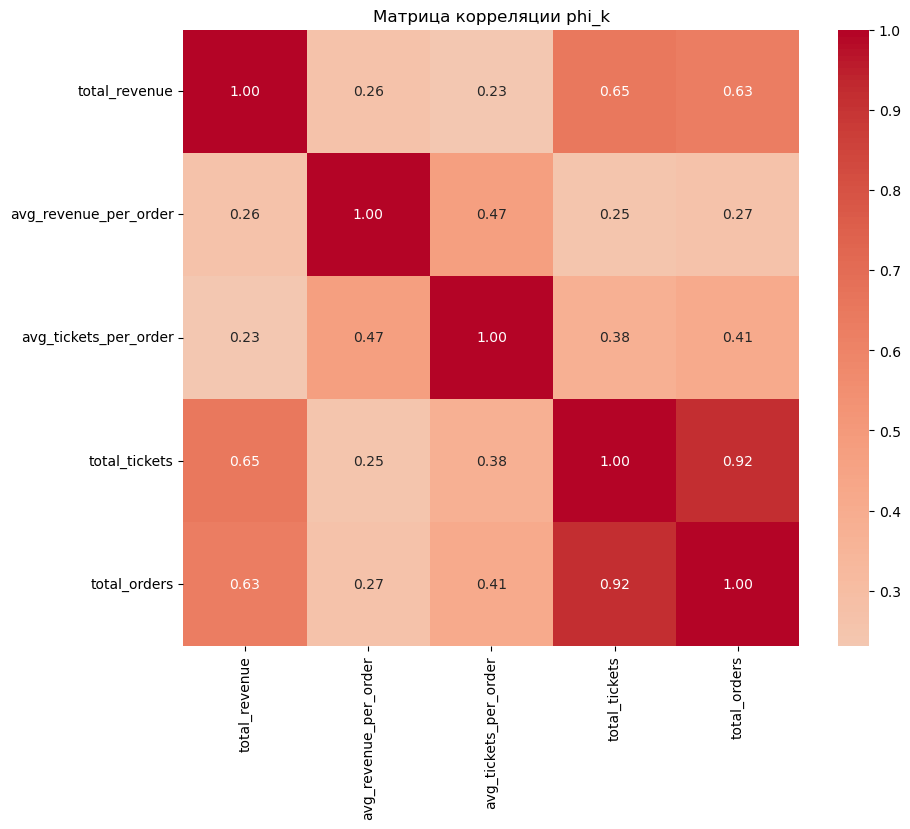

In [149]:
plt.figure(figsize=(10, 8))
sns.heatmap(
     corr_phik_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    square=True,
    fmt='.2f'
)
plt.title("Матрица корреляции phi_k")
plt.show()

Ключевые драйверы числа заказов — метрики: total_orders полностью определяются количеством покупок.
Поведенческий индикатор — total_tickets : его высокая корреляция говорит, что частота покупок связана с ростом среднего чека.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Выводы по этому разделу нужно актуализировать.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

---

В исходном представленном датасете 290611 строк и 15 столбцов.\
В таблице представлены данные разных типов (целочисленные значения, значения с палвающей точкой, строковый тип данных, данные типа datetime). Пропуски обнаружены в столбце days_since_prev (21933 пропуска).\
Однако, учитывая условия наличия в данном столбце значений NaN, было принято решение оставить пропуски без изменений.

Во время предобработки данных было произведенро приведение выручки к единой валюте — российскому рублю. А результаты преобразования сохраните в новый столбец `revenue_rub`.\
В этом столбце были обнаружены выбросы и затем отфильтрованы значения этого столбца по 99 перцентилю.\
Удалено 2823 строки.\
Также по 99-перцентилю столбца `tickets_count` были удалены 188 строк.\
После предобработки данных в датасете осталось 287600 строк.

Далее были построены агрегированные признаки, описывающие поведение и профиль каждого пользователя.\
Общее количество пользователей - 21847.\
Средняя выручка с одного заказа: 544.18 руб.\
Доля пользователей с 2+ заказами: 61.7%\
Доля пользователей с 5+ заказами: 29.0%

Тип устройства значительно сказался на возврат пользователей: desktop-заказы опередили mobile-заказы в процентном соотношении.

Пользлователи группы "2-4 заказов" делали в основном дешевые заказы (с низкой выручкой - 0-100 руб.), а те пользователи, которые делали 5+ заказов, платили в среднем 500 руб.

Основную часть пользователей составляют те, кто покупал 2-5 билетов.\
Аномально высоким является сегмент 2-3 билета в том время, как аномально низким - сегмент 5+ билетов (>8000 пользователей в среднем и 70% от общей доли повторных покупателей, <2000 и ~20%, соответственно)

Полученные данные демонстрируют какова частота повторных покупок между двумя группами пользователей:
пользователи с 2–4 заказами совершают повторные покупки в среднем раз в 21,3 дня, в то время как пользователи с 5+ заказами — почти вдвое чаще: раз в 11,1 дня.

Столбцы `total_orders` и `total_tickets` определяются количеством покупок согласно результатам корреляционного анализа. 

Пользователи с 5+ заказами (29 % аудитории), совершают покупки в 2 раза чаще чем группа с 2-4 заказми и платят в среднем 500 руб. за заказ (против 0–100 руб. у группы 2–4). Поэтому рекомендую создавать для них персонализированные предложения на основе истории покупок (например, «вам может понравиться» с скидкой 15 %) и реферальные программы (например, +20 % бонус за привлечение друзей к следующему заказу).  

Пользователей с 2–4 заказами (32,7 % аудитории), уже проявивших интерес, но не стали лояльными и склонных к дешёвым заказам (0–100 руб.) стимулировать пакетными предложениями («Купите 3 билета — 4‑й в подарок») и скидками на сопутствующие товары, а также предложить им накопление баллов за каждый заказ (например, 1 балл = 10 руб., 500 баллов = VIP‑статус).

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Твой итоговый вывод (который представляет собой рекомендации) выполнен безупречно. Он полностью основан на тех результатах анализа, которые ты привел в сводке. Ты правильно выделил два ключевых сегмента (2-4 заказа и 5+ заказов) и точно описал их характеристики. Все цифры - доли аудитории (29% и 32.7%), разница в частоте покупок (в 2 раза) и различия в среднем чеке (500 руб. против 0-100 руб.) - в точности взяты из твоего же анализа. Рекомендации, которые ты даешь, логично следуют из этих данных.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

[Ссылка на мой репозиторий на GitHub](https://github.com/username030124/project_yandex.git)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> Материалы проекта размещены в репозитории.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> В файл `README.md` можно добавить итоговый вывод по проекту.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> `.env` файл нельзя размещать в репозитории - фактически ты делаешь общедоступными приватные параметры подключения в базе данных, открывая к ней путь злоумышленникам.
    
В версии, которую ты заливаешь на `GitHub`, не стоит оставлять параметры подключения в явном виде - это может привести к несанкционированному доступу к данным, что чревато их потереей или изменением. Лучшее решение - локально создать `.env` файл, из которого с помощью `os` эти параметры подключения передаются в код. А файл `.gitignore` поможет не отслеживать этот файл для репозитория.
    
Файл `.env` может выглядеть так:

```python
DB_NAME="..."
DB_HOST="..."
DB_PORT="..."
DB_USER="..."
DB_PASSWORD="..."
```
    
В самом проекте мы можем обращаться к сохраненным параметрам с помощью библиотеки `dotenv`, чтобы загрузить переменные окружения, и `os`, чтобы обратиться к ним:
    
```python
import os
import dotenv
    
load_dotenv() # автоматически ищет .env в текущей директории
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)
```

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Азат, проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)